In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Импортирем необходимые нам библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 

# Перечислим модели для обучения
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

In [3]:
# Чтение и загрузка данных

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test  = pd.read_csv("/kaggle/input/titanic/test.csv")

# После загрузки данных, посмотрим на то что мы загрузили))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Поскольку изначальный датасет разделёна на 2 выборки, соеденим их с помощью конкатенации
df = pd.concat([train, test], ignore_index=True, sort = False)

# Проверим успешность соедниенеия данных для этого узнаем размер исходного датасета, а так же размерности датасетов из которых мы из собрали
print('Размер исходного датасета:')
print('В нем: {} строчек и {} столбцов (оригинальный датасет).'.format(df.shape[0], df.shape[1]))
print('Размер обучающего датасета:')
print('В нем: {} строчек и {} столбцов (обучающая выборка).'.format(train.shape[0], train.shape[1]))
print('Размер тестового датасета:')
print('В нем: {} строчек и {} столбцов (тестовая выборка).'.format(test.shape[0], test.shape[1]))


Размер исходного датасета:
В нем: 1309 строчек и 12 столбцов (оригинальный датасет).
Размер обучающего датасета:
В нем: 891 строчек и 12 столбцов (обучающая выборка).
Размер тестового датасета:
В нем: 418 строчек и 11 столбцов (тестовая выборка).


In [5]:
# Воспорльзуемся .info() для проверки заполнение строк и сбора информации о типах признаков 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [6]:
# Посмотрим на числовые параметры переменных для этого воспользуемся .describe

df.describe().style.background_gradient(cmap ='GnBu')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
# Посмотрим на колличество пропущенных значений

df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

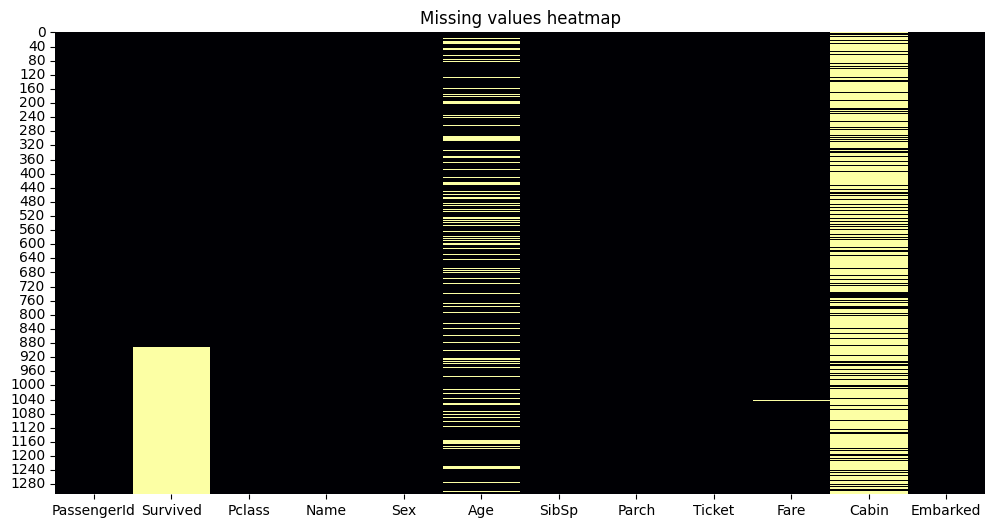

In [8]:
# С помощью тепловой карты построим график пропущенных значений

df.isnull().sum()
plt.figure(figsize = (12,6))
sns.heatmap(df.isnull(), cbar = False, cmap = 'inferno').set_title("Missing values heatmap");

In [9]:
# Тогда можно подытожить, что для всего датасета мы имеем

def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df) * 100
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum
summary(df).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
PassengerId,int64,0,0.000000,1309,1309
Survived,float64,418,31.932773,2,891
Pclass,int64,0,0.000000,3,1309
Name,object,0,0.000000,1307,1309
Sex,object,0,0.000000,2,1309
Age,float64,263,20.091673,98,1046
SibSp,int64,0,0.000000,7,1309
Parch,int64,0,0.000000,8,1309
Ticket,object,0,0.000000,929,1309
Fare,float64,1,0.076394,281,1308


In [10]:
# Для данных train

summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
PassengerId,int64,0,0.000000,891,891
Survived,int64,0,0.000000,2,891
Pclass,int64,0,0.000000,3,891
Name,object,0,0.000000,891,891
Sex,object,0,0.000000,2,891
Age,float64,177,19.865320,88,714
SibSp,int64,0,0.000000,7,891
Parch,int64,0,0.000000,7,891
Ticket,object,0,0.000000,681,891
Fare,float64,0,0.000000,248,891


In [11]:
# Для данных test

summary(test).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
PassengerId,int64,0,0.000000,418,418
Pclass,int64,0,0.000000,3,418
Name,object,0,0.000000,418,418
Sex,object,0,0.000000,2,418
Age,float64,86,20.574163,79,332
SibSp,int64,0,0.000000,7,418
Parch,int64,0,0.000000,8,418
Ticket,object,0,0.000000,363,418
Fare,float64,1,0.239234,169,417
Cabin,object,327,78.229665,76,91


<Axes: xlabel='Embarked', ylabel='count'>

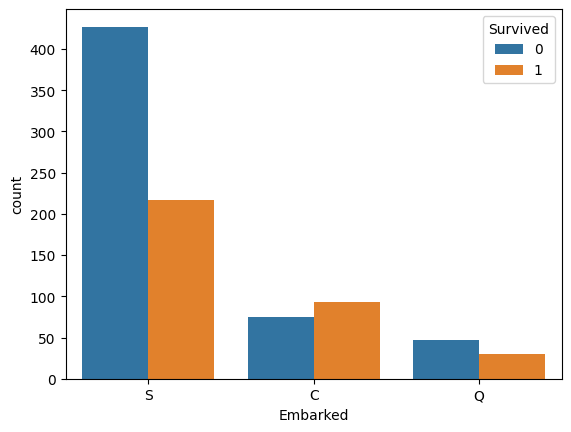

In [12]:
#  Есть три возможных значения для Embarked -  Саутгемптон, Шербург и Куинстаун - эта переменная отвечает за порт посадки пасажиров

sns.countplot(data=train, x='Embarked', hue='Survived')

In [13]:
# Поработаем с пропущенными значениями

# Embarked - место посадки, тк колличиство пропущенных значений мало, 
# а так же нам известно откуда оправлялось большинство пасажиров, заполним отсутствующие значения наиболее часто встречающемся элементом в выборке 

    #df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Cabin - номер каюты
# заменим отсутствующие значения на "NA", так как мы не будем использовать этот признак для обучения модели

    #df['Cabin'].fillna('NA', inplace=True)

test['Cabin'].fillna('NA', inplace=True)
train['Cabin'].fillna('NA', inplace=True)

# Age - возраст
# заменим отсутствующие значения на медианное значение этой переменной

    #df['Age'].fillna(df['Age'].median, inplace=True)

test['Age'].fillna(test['Age'].median(), inplace=True)
train['Age'].fillna(train['Age'].median(), inplace=True)

test['Age'] = test['Age'].astype('int')
train['Age'] = train['Age'].astype('int')

In [14]:
# Теперь ещё раз посмотрим на колличество пропущенных значений

print('Данные пропущенные данные - "train"')
print(train.isnull().sum())

print('\n')

print('Данные пропущенные данные - "test"')
print(test.isnull().sum())

Данные пропущенные данные - "train"
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


Данные пропущенные данные - "test"
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
dtype: int64


In [15]:
# Видим что мы пропустили одно NAN значение для признака Fare - заполним его медианной величиной
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [16]:
# Кодирование категориальных признаков

# LabelEncoder заменит «мужские» значения одним числом (в нашем случае 1), а «женские» значения — другим числом.
    
train['Sex'] = LabelEncoder().fit_transform(train['Sex'])
test['Sex'] = LabelEncoder().fit_transform(test['Sex'])

#  Get_dummies создаст три различных столбца и назначит значения 0 или 1 в зависимости от соответствия значения этому столбцу.
    
dummies_train = pd.get_dummies(train['Embarked']).astype(int)
dummies_test = pd.get_dummies(test['Embarked']).astype(int)

train = pd.concat([train, dummies_train], axis=1)
test = pd.concat([test, dummies_test], axis=1)

In [17]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NA,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NA,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NA,S,0,0,1


In [18]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,Q,S
0,892,3,"Kelly, Mr. James",1,34,0,0,330911,7.8292,NA,Q,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47,1,0,363272,7.0000,NA,S,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",1,62,0,0,240276,9.6875,NA,Q,0,1,0
3,895,3,"Wirz, Mr. Albert",1,27,0,0,315154,8.6625,NA,S,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22,1,1,3101298,12.2875,NA,S,0,0,1


In [19]:
# Посмотрим на колонки
train.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'C', 'Q', 'S'],
      dtype='object')

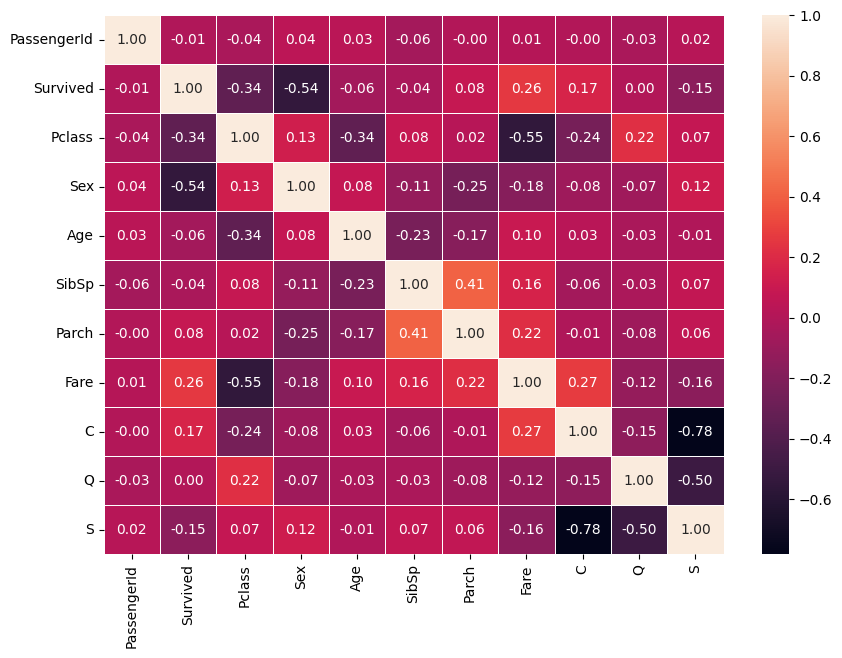

In [20]:
selected_features = [
    'PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
    'Parch', 'Fare', 'C', 'Q', 'S']

# Plot the heatmap
plt.figure(figsize=(10, 7), dpi = 100)
sns.heatmap(
    train[selected_features].corr(),
    annot=True,
    fmt=".2f",
    linewidths=.5
);

In [21]:
# Разбиваем данные на train и hold_out

X = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Embarked', 'Cabin'], axis = 1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, 165 to 102
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  801 non-null    int64  
 1   Sex     801 non-null    int64  
 2   Age     801 non-null    int64  
 3   SibSp   801 non-null    int64  
 4   Parch   801 non-null    int64  
 5   Fare    801 non-null    float64
 6   C       801 non-null    int64  
 7   Q       801 non-null    int64  
 8   S       801 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 62.6 KB


In [23]:
# Напишем функцию для обработки результатов и построения ROC графика

def prediction_function(model):
    # Получаем лучшую модель из GridSearchCV
    best_model = model.best_estimator_

    # Получаем предсказания на НЕ отмасштабированных тестовых данных
    predictions = best_model.predict(X_test)

    # Оценка точности
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Classification Report
    class_report = classification_report(y_test, predictions)
    print(f'Classification Report:\n{class_report}')
    
    # ROC Curve (если модель поддерживает вероятности)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # Вероятности для класса 1
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Построение ROC-кривой

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show();
        
    else:
        print("Модель не поддерживает предсказание вероятности.")    

In [24]:
# Определение операций для пайплайна
scaler = StandardScaler()
log_model = LogisticRegression()

# Список операций для пайплайна
operations_log_model = [('scaler', scaler), ('log_model', log_model)]

# Создание пайплайна
pipe_log_model = Pipeline(operations_log_model)

# Определение значений для перебора
param_grid_log_model = {
    'log_model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'log_model__penalty': ['l1', 'l2'],
    'log_model__solver': ['liblinear', 'saga'],
    'log_model__max_iter': [100, 500, 1000]
}

# Инициализация GridSearchCV
full_cv_classifier_log_model = GridSearchCV(pipe_log_model, param_grid_log_model, cv=5, scoring='neg_mean_squared_error')

# Обучение модели с помощью GridSearchCV
full_cv_classifier_log_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_model', LogisticRegression())]),
             param_grid={'log_model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'log_model__max_iter': [100, 500, 1000],
                         'log_model__penalty': ['l1', 'l2'],
                         'log_model__solver': ['liblinear', 'saga']},
             scoring='neg_mean_squared_error')

In [25]:
full_cv_classifier_log_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('log_model', LogisticRegression(C=0.01, solver='saga'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'log_model': LogisticRegression(C=0.01, solver='saga'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'log_model__C': 0.01,
 'log_model__class_weight': None,
 'log_model__dual': False,
 'log_model__fit_intercept': True,
 'log_model__intercept_scaling': 1,
 'log_model__l1_ratio': None,
 'log_model__max_iter': 100,
 'log_model__multi_class': 'auto',
 'log_model__n_jobs': None,
 'log_model__penalty': 'l2',
 'log_model__random_state': None,
 'log_model__solver': 'saga',
 'log_model__tol': 0.0001,
 'log_model__verbose': 0,
 'log_model__warm_start': False}

In [26]:
# Создадим пайплайн для KNN
# Определение операций для пайплайна
scaler = StandardScaler()
knn = KNeighborsClassifier()
operations_knn = [('scaler', scaler), ('knn', knn)]

# Создание пайплайна
pipe_knn = Pipeline(operations_knn)

# Определение значений k для поиска лучшего значения
k_values = list(range(1, 21))
param_grid_knn = {
    'knn__n_neighbors': k_values,
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev']
}

# Инициализация GridSearchCV
full_cv_classifier_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='accuracy')

# Обучение модели с помощью GridSearchCV
full_cv_classifier_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [27]:
full_cv_classifier_knn.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors=18))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(metric='manhattan', n_neighbors=18),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'manhattan',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 18,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [28]:
# Создадим пайплайн для DecisionTreeClassifier
# Определение операций для пайплайна
scaler = StandardScaler()
tree_model = DecisionTreeClassifier()
operations_tree_model = [('scaler', scaler), ('tree_model', tree_model)]

# Создание пайплайна
pipe_tree_model = Pipeline(operations_tree_model)

# Определение значений для поиска лучшего значения
param_grid_tree = {
    'tree_model__max_depth': [None, 5, 10, 15, 20],
    'tree_model__min_samples_split': [2, 5, 10],
    'tree_model__min_samples_leaf': [1, 2, 4]
}

# Инициализация GridSearchCV
full_cv_classifier_tree_model = GridSearchCV(pipe_tree_model, param_grid_tree, cv=5, scoring='accuracy')

# Обучение модели с помощью GridSearchCV
full_cv_classifier_tree_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree_model',
                                        DecisionTreeClassifier())]),
             param_grid={'tree_model__max_depth': [None, 5, 10, 15, 20],
                         'tree_model__min_samples_leaf': [1, 2, 4],
                         'tree_model__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [29]:
full_cv_classifier_tree_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('tree_model', DecisionTreeClassifier(max_depth=5, min_samples_split=10))],
 'verbose': False,
 'scaler': StandardScaler(),
 'tree_model': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'tree_model__ccp_alpha': 0.0,
 'tree_model__class_weight': None,
 'tree_model__criterion': 'gini',
 'tree_model__max_depth': 5,
 'tree_model__max_features': None,
 'tree_model__max_leaf_nodes': None,
 'tree_model__min_impurity_decrease': 0.0,
 'tree_model__min_samples_leaf': 1,
 'tree_model__min_samples_split': 10,
 'tree_model__min_weight_fraction_leaf': 0.0,
 'tree_model__random_state': None,
 'tree_model__splitter': 'best'}

In [30]:
# Создадим пайплайн для RandomForestClassifier
# Определение операций для пайплайна
scaler = StandardScaler()
rf_model = RandomForestClassifier()
operations_rf_model = [('scaler', scaler), ('rf_model', rf_model)]

# Создание пайплайна
pipe_rf_model = Pipeline(operations_rf_model)

# Определение значений для поиска лучшего значения
param_rf_model = {
    'rf_model__n_estimators': [100, 300, 500],
    'rf_model__max_depth': [None, 5, 10, 15],
}

# Инициализация GridSearchCV
full_cv_classifier_rf_model = GridSearchCV(pipe_rf_model, param_rf_model, cv=5, scoring='accuracy')

# Обучение модели с помощью GridSearchCV
full_cv_classifier_rf_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf_model', RandomForestClassifier())]),
             param_grid={'rf_model__max_depth': [None, 5, 10, 15],
                         'rf_model__n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [31]:
full_cv_classifier_rf_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('rf_model', RandomForestClassifier(max_depth=5))],
 'verbose': False,
 'scaler': StandardScaler(),
 'rf_model': RandomForestClassifier(max_depth=5),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf_model__bootstrap': True,
 'rf_model__ccp_alpha': 0.0,
 'rf_model__class_weight': None,
 'rf_model__criterion': 'gini',
 'rf_model__max_depth': 5,
 'rf_model__max_features': 'sqrt',
 'rf_model__max_leaf_nodes': None,
 'rf_model__max_samples': None,
 'rf_model__min_impurity_decrease': 0.0,
 'rf_model__min_samples_leaf': 1,
 'rf_model__min_samples_split': 2,
 'rf_model__min_weight_fraction_leaf': 0.0,
 'rf_model__n_estimators': 100,
 'rf_model__n_jobs': None,
 'rf_model__oob_score': False,
 'rf_model__random_state': None,
 'rf_model__verbose': 0,
 'rf_model__warm_start': False}

In [32]:
# Создадим пайплайн для GradientBoostingClassifier
# Определение операций для пайплайна
scaler = StandardScaler()
gb_model = GradientBoostingClassifier()
operations_gb_model = [('scaler', scaler), ('gb_model', gb_model)]

# Создание пайплайна
pipe_gb_model = Pipeline(operations_gb_model)

# Определение значений для поиска лучшего значения
param_gb_model = {
    'gb_model__n_estimators': [100, 200, 300],
    'gb_model__max_depth': [3, 5, 7]
}

# Инициализация GridSearchCV
full_cv_classifier_gb_model = GridSearchCV(pipe_gb_model, param_gb_model, cv=5, scoring='accuracy')

# Обучение модели с помощью GridSearchCV
full_cv_classifier_gb_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gb_model',
                                        GradientBoostingClassifier())]),
             param_grid={'gb_model__max_depth': [3, 5, 7],
                         'gb_model__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [33]:
full_cv_classifier_gb_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('gb_model', GradientBoostingClassifier(n_estimators=300))],
 'verbose': False,
 'scaler': StandardScaler(),
 'gb_model': GradientBoostingClassifier(n_estimators=300),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'gb_model__ccp_alpha': 0.0,
 'gb_model__criterion': 'friedman_mse',
 'gb_model__init': None,
 'gb_model__learning_rate': 0.1,
 'gb_model__loss': 'log_loss',
 'gb_model__max_depth': 3,
 'gb_model__max_features': None,
 'gb_model__max_leaf_nodes': None,
 'gb_model__min_impurity_decrease': 0.0,
 'gb_model__min_samples_leaf': 1,
 'gb_model__min_samples_split': 2,
 'gb_model__min_weight_fraction_leaf': 0.0,
 'gb_model__n_estimators': 300,
 'gb_model__n_iter_no_change': None,
 'gb_model__random_state': None,
 'gb_model__subsample': 1.0,
 'gb_model__tol': 0.0001,
 'gb_model__validation_fraction': 0.1,
 'gb_model__verbose': 0,
 'gb_model__warm_start': False}

In [34]:
# Создадим пайплайн для GradientBoostingClassifier
# Определение операций для пайплайна
scaler = StandardScaler()
svc_model = SVC()
operations_svc_model = [('scaler', scaler), ('svc_model', svc_model)]

# Создание пайплайна
pipe_svc_model = Pipeline(operations_svc_model)

# Определение значений для поиска лучшего значения
param_svc_model = {
    'svc_model__C': [0.1, 1, 10],
    'svc_model__kernel': ['linear', 'rbf'],
    'svc_model__gamma': ['scale', 'auto']
}

# Инициализация GridSearchCV
full_cv_classifier_svc_model = GridSearchCV(pipe_svc_model, param_svc_model, cv=5, scoring='accuracy')

# Обучение модели с помощью GridSearchCV
full_cv_classifier_svc_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc_model', SVC())]),
             param_grid={'svc_model__C': [0.1, 1, 10],
                         'svc_model__gamma': ['scale', 'auto'],
                         'svc_model__kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [35]:
full_cv_classifier_svc_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('svc_model', SVC(C=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'svc_model': SVC(C=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'svc_model__C': 1,
 'svc_model__break_ties': False,
 'svc_model__cache_size': 200,
 'svc_model__class_weight': None,
 'svc_model__coef0': 0.0,
 'svc_model__decision_function_shape': 'ovr',
 'svc_model__degree': 3,
 'svc_model__gamma': 'scale',
 'svc_model__kernel': 'rbf',
 'svc_model__max_iter': -1,
 'svc_model__probability': False,
 'svc_model__random_state': None,
 'svc_model__shrinking': True,
 'svc_model__tol': 0.001,
 'svc_model__verbose': False}

Accuracy: 0.8222222222222222
Confusion Matrix:
[[45  9]
 [ 7 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        54
           1       0.76      0.81      0.78        36

    accuracy                           0.82        90
   macro avg       0.81      0.82      0.82        90
weighted avg       0.82      0.82      0.82        90



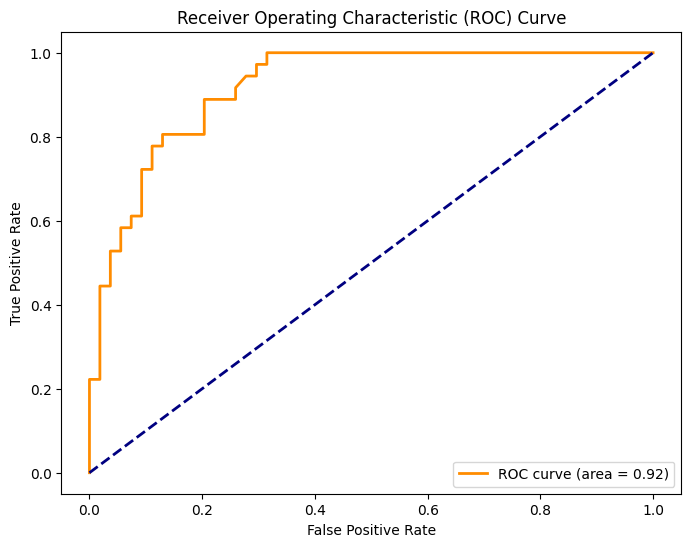

In [36]:
# Визумализируем результаты для каждой из моделей
prediction_function(full_cv_classifier_gb_model)

Accuracy: 0.8444444444444444
Confusion Matrix:
[[48  6]
 [ 8 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        54
           1       0.82      0.78      0.80        36

    accuracy                           0.84        90
   macro avg       0.84      0.83      0.84        90
weighted avg       0.84      0.84      0.84        90



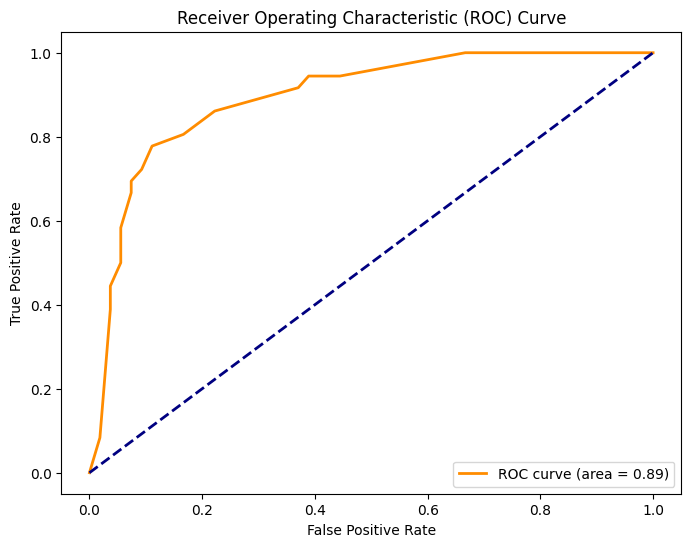

In [37]:
# Визумализируем результаты для каждой из моделей
prediction_function(full_cv_classifier_knn)

Accuracy: 0.8444444444444444
Confusion Matrix:
[[48  6]
 [ 8 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        54
           1       0.82      0.78      0.80        36

    accuracy                           0.84        90
   macro avg       0.84      0.83      0.84        90
weighted avg       0.84      0.84      0.84        90



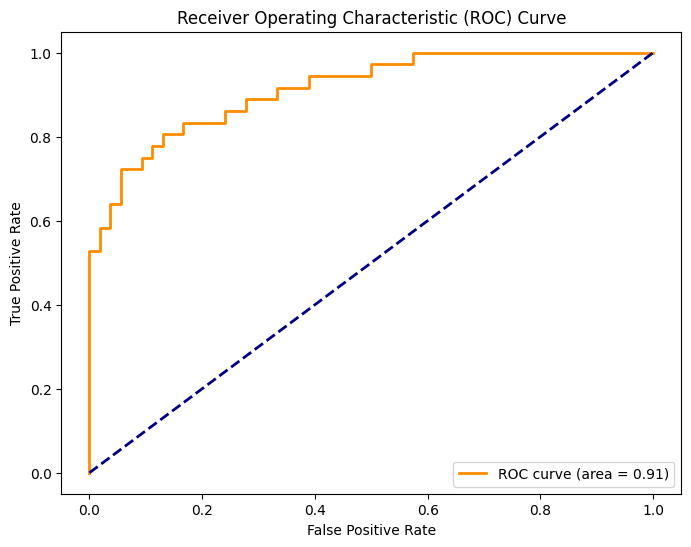

In [38]:
# Визумализируем результаты для каждой из моделей
prediction_function(full_cv_classifier_log_model)

Accuracy: 0.8333333333333334
Confusion Matrix:
[[48  6]
 [ 9 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        54
           1       0.82      0.75      0.78        36

    accuracy                           0.83        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.83      0.83      0.83        90



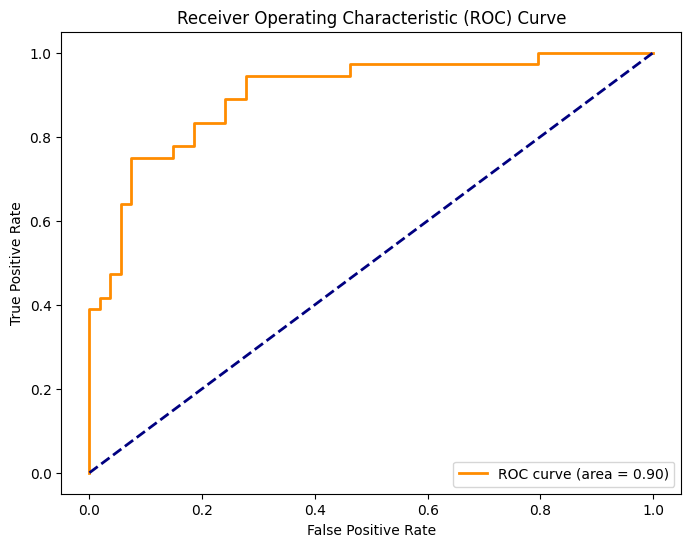

In [39]:
# Визумализируем результаты для каждой из моделей
prediction_function(full_cv_classifier_rf_model)

In [40]:
# Визумализируем результаты для каждой из моделей
prediction_function(full_cv_classifier_svc_model)

Accuracy: 0.8333333333333334
Confusion Matrix:
[[48  6]
 [ 9 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        54
           1       0.82      0.75      0.78        36

    accuracy                           0.83        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.83      0.83      0.83        90

Модель не поддерживает предсказание вероятности.


Accuracy: 0.7666666666666667
Confusion Matrix:
[[49  5]
 [16 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        54
           1       0.80      0.56      0.66        36

    accuracy                           0.77        90
   macro avg       0.78      0.73      0.74        90
weighted avg       0.77      0.77      0.76        90



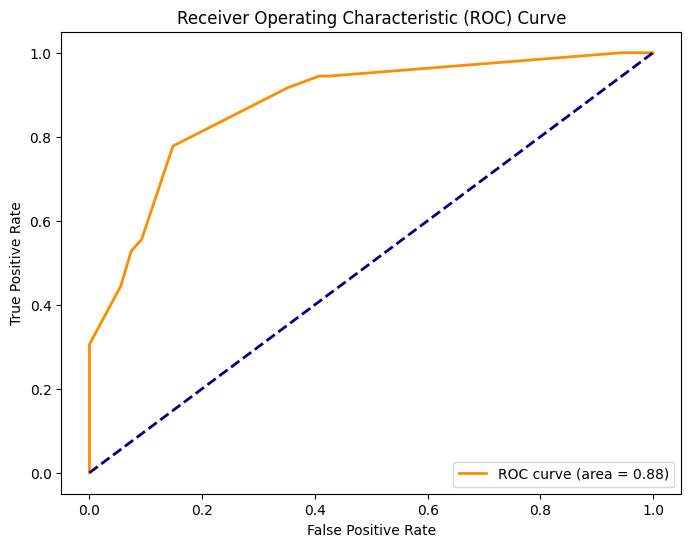

In [41]:
# Визумализируем результаты для каждой из моделей
prediction_function(full_cv_classifier_tree_model)

In [42]:
# Проанализировав полученные результаты точности для исследуемых моделей, перейдём к формированию ответов на поставленную задачу

final_test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis = 1)

final_predictions_log_model = full_cv_classifier_log_model.best_estimator_.predict(final_test)

In [43]:
# Формируем результаты
result = pd.DataFrame(columns=['PassengerId', 'Survived'])
result['PassengerId'] = test['PassengerId']
result['Survived'] = final_predictions_log_model

result = result.set_index('PassengerId')

In [44]:
result

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [45]:
result.to_csv('submission.csv')

In [46]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': final_predictions_log_model})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
